In [1]:
import wandb
import pandas as pd

# Configurable list of run names
run_names = ["encoder_2d_nojit", "encoder_torus", "encoder_sphere"]

# W&B project info
entity = "dagerber-massachusetts-institute-of-technology"
project = "encoder_training"

# Metrics to extract (one CSV per metric)
metrics_of_interest = [
    "train/loss",
    "test/loss",
]

# Initialize W&B API
api = wandb.Api()

# Loop over each metric separately
for metric in metrics_of_interest:
    metric_dataframes = []

    for run_name in run_names:
        # Find the run by display name
        runs = api.runs(f"{entity}/{project}", filters={"display_name": run_name})

        if not runs:
            print(f"Run '{run_name}' not found. Skipping.")
            continue

        run = runs[0]

        # Use scan_history() to ensure full history is retrieved
        rows = []
        for row in run.scan_history():
            if metric in row and "_step" in row:
                rows.append({
                    "step": row["_step"],
                    run_name: row[metric]
                })

        if not rows:
            print(f"No data found for '{metric}' in run '{run_name}'. Skipping.")
            continue

        df = pd.DataFrame(rows)
        metric_dataframes.append(df)

    # Merge all runs on step
    if metric_dataframes:
        merged_df = metric_dataframes[0]
        for df in metric_dataframes[1:]:
            merged_df = pd.merge(merged_df, df, on="step", how="outer")

        # Sort by step
        merged_df = merged_df.sort_values("step")

        # Save to CSV
        safe_metric_name = metric.replace("/", "_")
        csv_filename = f"{safe_metric_name}_merged.csv"
        merged_df.to_csv(csv_filename, index=False)
        print(f"Saved: {csv_filename}")
    else:
        print(f"No valid data found for metric: {metric}")


Saved: train_loss_merged.csv
Saved: test_loss_merged.csv


# Plot

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib

matplotlib.rcParams.update({
    "text.usetex": True,                # Use LaTeX for all text
    "font.family": "serif",             # Use serif font
    "font.serif": ["Charter"],
    "text.latex.preamble": r"\usepackage{charter}",
    "axes.labelsize": 18,      # Axis label font size (yours is 22)
    "axes.titlesize": 18,      # Title font size (add this for plot title)
    "font.size": 16,           # Default font size (yours is 12)
    "legend.fontsize": 14,     # Legend font size (yours is 12)
    "xtick.labelsize": 16,     # X tick labels
    "ytick.labelsize": 16,     # Y tick labels
})

In [2]:
def plot_data(
    csv_file, columns, steps, xlabel, ylabel,
    log_scale=False, output='plot.png', percent_y=False
):
    # Define RGB colors
    color_list = [
        (0.96, 0, 0.42),      # pink
        (0.216, 0.522, 0.882),# blue
        (0.22, 0.827, 0.835)  # cyan
    ]

    df = pd.read_csv(csv_file, usecols=columns.keys())
    df.rename(columns=columns, inplace=True)

    columns = list(columns.values())

    for col in columns[1:]:
        df[f'{col}_avg'] = df[col].rolling(steps, min_periods=1).mean()

    fig, ax = plt.subplots(figsize=(10, 6))
    x = df[columns[0]]
    x = x/x[0]

    for idx, col in enumerate(columns[1:]):
        color = color_list[idx % len(color_list)]
        ax.plot(x, df[col], color=color, alpha=0.45, linewidth=1, linestyle='dotted', label=f'{col} -- Raw', zorder=1)
        ax.plot(x, df[f'{col}_avg'], color=color, alpha=1.0, linewidth=2, label=f'{col} -- Average', zorder=2)

    ax.set(xlabel=xlabel, ylabel=ylabel)
    if log_scale:
        ax.set_yscale('log')
    if percent_y:
        # Append % symbol to y-axis labels without changing values
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: r"${:.0f}\%$".format(y)))

    ax.legend()
    ax.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.savefig(output, format='pdf', transparent=True, bbox_inches='tight')
    plt.show()
    plt.close()

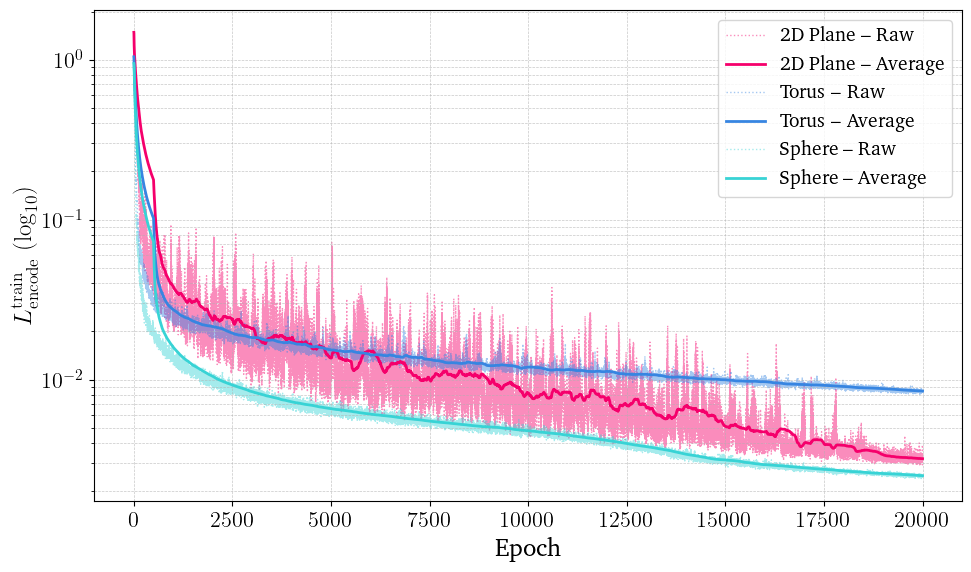

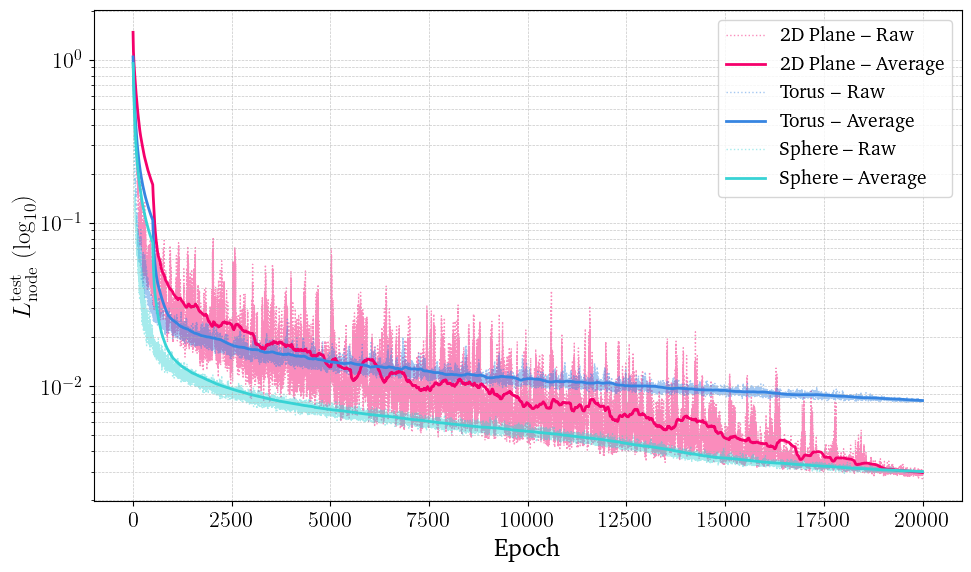

In [4]:
losses = ["train", "test"]
losses_latex = [
    r"$L_{\mathrm{encode}}^{\mathrm{train}} \ (\log_{10})$",
    r"$L_{\mathrm{node}}^{\mathrm{test}} \ (\log_{10})$",
]
# steps = [100]
for loss, loss_latex in zip(losses, losses_latex):
    run_names = ["encoder_2d_nojit", "encoder_torus", "encoder_sphere"]
    columns = {
        'step': 'Step',
        'encoder_2d_nojit': '2D Plane',
        'encoder_torus': 'Torus',
        'encoder_sphere': 'Sphere'
    }
    plot_data(
        csv_file=f'csv_files/{loss}_loss_merged_enc.csv',
        columns=columns,
        steps=500,
        xlabel = 'Epoch',
        ylabel=f'{loss_latex}',
        log_scale=True,
        output=f'losses_encoder/{loss}.pdf',
        percent_y=False
    )